# Machine Learning

## Table of Contents

1. **Introduction to Machine Learning**
    - [Objective](#ml-objective)
    - [Evaluation Metrics](#evaluation-metrics)
      
2. **Data Loading**
    - [Importing Libraries](#Importing-Libraries)
    - [Loading the Dataset](#Loading-the-Dataset)

3. **Feature Definition**
    - [Defining Numeric and Categorical Features](#Defining-Numeric-and-Categorical-Features)

4. **Data Splitting**
    - [Separating Features (X) and Target Variable (y)](#Separating-Features-and-Target-Variable)

5. **Data Preprocessing**
    - [Preprocessing Steps for Numeric and Categorical Features](#Preprocessing-Steps-for-Numeric-and-Categorical-Features)
    - [Combining Preprocessing Steps](#Combining-Preprocessing-Steps)

6. **Model Definition**
    - [Creating the Time Series Split](#Creating-the-Time-Series-Split)
    - [Defining the XGBoost Model](#Defining-the-XGBoost-Model)

7. **Pipeline Creation**
    - [Defining the Pipeline](#Defining-the-Pipeline)

8. **Hyperparameter Tuning**
    - [Defining the Hyperparameter Space](#Defining-the-Hyperparameter-Space)
    - [Creating and Fitting the RandomizedSearchCV](#Creating-and-Fitting-the-RandomizedSearchCV)

9. **Model Evaluation**
    - [Performing Cross-Validation on the Best Model](#Performing-Cross-Validation-on-the-Best-Model)

10. **Final Model Fitting and Predictions**
    - [Fitting the Best Model on the Training Data](#Fitting-the-Best-Model-on-the-Training-Data)
    - [Making Predictions on the Test Data Using Best Model](#Making-Predictions-on-the-Test-Data-Using-Best-Model)
    - [Calculating and Printing Error Metrics](#Calculating-and-Printing-Error-Metrics)

11. **Feature Importance**
    - [Computing Feature Importance](#Computing-Feature-Importance)

12. **Predictions**
    - [Making Predictions on the Test Data](#Making-Predictions-on-the-Test-Data)
    - [Creating a Dataset with True and Predicted Demand](#Creating-a-Dataset-with-True-and-Predicted-Demand)

13. **Results Visualization**
    - [Plotting Hourly Electricity Demand: True vs Predicted](#Plotting-Hourly-Electricity-Demand-True-vs-Predicted)

14. **Filtering Data for Specific Day**
    - [Filtering Data for a Specific Day](#Filtering-Data-for-a-Specific-Day)

15. **Conclusion**
    - [Summary of Results](#Summary-of-Results)
    - [Future Work](#Future-Work)
    - [References](#References)


# Machine Learning

## Introduction to Machine Learning

### Objective
<a id="ml-objective"></a>
The objective of utilizing machine learning on this dataset, specifically for electricity demand prediction, is to utilize historical data alongside pertinent features (like temperature, humidity, day of the week, holidays, etc.) to construct models capable of precisely predicting future patterns in electricity consumption.

### Evaluation Metrics
<a id="evaluation-metrics"></a>

In evaluating my model for predicting electricity demand, I utilized several key metrics to assess its performance:

- **Mean Absolute Error (MAE)**: This metric quantifies the average magnitude of errors between predicted and actual values, providing a straightforward measure of prediction accuracy.
  
- **Mean Squared Error (MSE)** and **Root Mean Squared Error (RMSE)**: MSE calculates the average squared differences between predictions and actual values, while RMSE represents the square root of MSE, providing a measure of prediction error in the same units as the predicted values.

- **R-squared (Coefficient of Determination)**: R-squared measures the proportion of the variance in the dependent variable (electricity demand) that is predictable from the independent variables (features), indicating how well the model fits the data.

- **Mean Absolute Percentage Error (MAPE)**: MAPE offers a relative measure of prediction accuracy by calculating the average percentage deviation of predictions from actual values.

These metrics collectively provide a comprehensive evaluation of the model's ability to predict electricity demand accurately, guiding decisions on model selection and performance optimization.


# Data Loading
## Importing Libraries

In [1]:
# Library installation, xgboost needs to install carefully on Mac
!pip install pandas numpy scikit-learn xgboost matplotlib seaborn


[notice] A new release of pip is available: 24.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

## Loading the Dataset
<a id="Loading-the-Dataset"></a>


In [4]:
# Load the data for ML
df = pd.read_pickle('./data/electricity_data_pre_ml.pkl') 

In [5]:
# Set the date as the index
df.set_index('Date', inplace=True)

## Feature Definition

### Defining Numeric and Categorical Features
<a id="Defining-Numeric-and-Categorical-Features"></a>


In [6]:
# Define features
numeric_features = [
    'HOEP', 'Temperature', 'Wind_Speed', 'Relative_Humidity', 
    'Pressure_Station', 'demand_lag_1', 'demand_lag_2', 'demand_lag_6', 
    'demand_lag_12', 'demand_lag_24', 'demand_lag_48', 'demand_lag_168', 
    'demand_rolling_mean_6', 'demand_rolling_mean_12', 'demand_rolling_mean_24', 
    'demand_rolling_mean_48', 'demand_rolling_mean_168', 'EWMA_6', 'EWMA_12', 
    'EWMA_24', 'EWMA_48', 'EWMA_168', 'Sin_Hour', 'Cos_Hour'
]
categorical_features = [
    'Hour', 'DayOfWeek', 'IsWeekend', 'IsHoliday', 'Year', 
    'Month', 'Season'
]

## Data Splitting

### Separating Features (X) and Target Variable (y)
<a id="Separating-Features-and-Target-Variable"></a>


In [7]:
# Separate features (X) and target variable (y)
X = df[numeric_features + categorical_features]
y = df['Ontario_Demand']

## Data Preprocessing

### Preprocessing Steps for Numeric and Categorical Features
<a id="Preprocessing-Steps-for-Numeric-and-Categorical-Features"></a>


In [8]:
# Define the preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

### Combining Preprocessing Steps
<a id="Combining-Preprocessing-Steps"></a>


In [9]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## Model Definition

### Creating the Time Series Split
<a id="Creating-the-Time-Series-Split"></a>


In [10]:
# Create the time series split
tscv = TimeSeriesSplit(n_splits=5, gap = 24)


Implemented `TimeSeriesSplit` with `n_splits=5` and `gap=24` because it facilitates a robust evaluation of my model on sequential data. This method maintains the temporal order of the dataset, which is crucial for realistic forecasting scenarios, thereby enhancing the reliability and generalizability of the model's performance assessment.

### Defining the XGBoost Model
<a id="Defining-the-XGBoost-Model"></a>


In [11]:
# # Define the XGBoost model with GPU acceleration
# xgb_model = xgb.XGBRegressor(
#     tree_method='gpu_hist',  # Use GPU for histogram-based learning
#     gpu_id=0,  # Specify GPU device (use gpu_id=0 for the first GPU)
#     random_state=42
# )


In [12]:
# Define the XGBoost model
xgb_model = xgb.XGBRegressor(
    tree_method='hist',  # Use CPU for histogram-based learning
    random_state=42
)


## Pipeline Creation

### Defining the Pipeline
<a id="Defining-the-Pipeline"></a>


In [13]:
# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb', xgb_model)
])

## Hyperparameter Tuning

### Defining the Hyperparameter Space
<a id="Defining-the-Hyperparameter-Space"></a>


In [14]:
# Define the hyperparameter space
param_space = {
    'xgb__n_estimators': [250, 275, 300, 325, 350, 375, 400],
    'xgb__max_depth': [6, 7, 8, 9],
    'xgb__learning_rate': [0.05, 0.075, 0.1, 0.125, 0.15],
    'xgb__subsample': [0.95, 0.975, 1.0],
    'xgb__colsample_bytree': [0.7, 0.75, 0.8, 0.85, 0.9],
    'xgb__min_child_weight': [1, 3, 5, 7],
    'xgb__gamma': [0, 0.1, 0.2, 0.3],
    'xgb__reg_alpha': [0, 0.1, 1, 10],
    'xgb__reg_lambda': [0, 0.1, 1, 10]
}

# Prev Best hyperparameters:
# xgb__subsample: 1.0
# xgb__n_estimators: 300
# xgb__max_depth: 7
# xgb__learning_rate: 0.1
# xgb__colsample_bytree: 0.8


I utilized `RandomizedSearchCV` to optimize my XGBoost model's hyperparameters for predicting electricity demand. Unlike `GridSearchCV`, which exhaustively searches through a specified grid of hyperparameters, `RandomizedSearchCV` randomly samples combinations from defined distributions (`param_dist`). This approach is beneficial when the hyperparameter search space is large, as it efficiently explores a diverse range of configurations while maintaining the integrity of time series cross-validation (`tscv`). By evaluating models based on their ability to minimize mean squared error (`neg_mean_squared_error`), I aimed to identify the optimal set of hyperparameters that enhance the model's predictive accuracy and robustness across varying time periods in the dataset.

### Creating and Fitting the RandomizedSearchCV
<a id="Creating-and-Fitting-the-RandomizedSearchCV"></a>


In [15]:
# Create the randomized search object
random_search = RandomizedSearchCV(
    pipeline, param_distributions=param_space, n_iter=50, cv=tscv, verbose = 2,
    scoring='neg_mean_squared_error', n_jobs=1, random_state=42
)

In [16]:
# Fit the randomized search
random_search.fit(X, y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END xgb__colsample_bytree=0.75, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=8, xgb__min_child_weight=5, xgb__n_estimators=400, xgb__reg_alpha=10, xgb__reg_lambda=0, xgb__subsample=1.0; total time=   0.8s
[CV] END xgb__colsample_bytree=0.75, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=8, xgb__min_child_weight=5, xgb__n_estimators=400, xgb__reg_alpha=10, xgb__reg_lambda=0, xgb__subsample=1.0; total time=   1.1s
[CV] END xgb__colsample_bytree=0.75, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=8, xgb__min_child_weight=5, xgb__n_estimators=400, xgb__reg_alpha=10, xgb__reg_lambda=0, xgb__subsample=1.0; total time=   1.3s
[CV] END xgb__colsample_bytree=0.75, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=8, xgb__min_child_weight=5, xgb__n_estimators=400, xgb__reg_alpha=10, xgb__reg_lambda=0, xgb__subsample=1.0; total time=   1.3s
[CV] END xgb__colsample_bytree=0.75, xgb__gamma=0, xgb__learning_r

RandomizedSearchCV(cv=TimeSeriesSplit(gap=24, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['HOEP',
                                                                                'Temperature',
                                                                                'Wind_Speed',
                                                                                'Relative_Humidity',
                                                                                'Pressure_Station',
                                                                                'demand_lag_1',
                                                                                'demand_lag_2'...
                                                                  0.8, 0.85,
                                                                  0.9],
                                        'xgb__gamma': [0, 0.1, 0.2, 0.3],
                                        'xgb__learning_rate': [0.05, 0.075, 0.1,
                                                               0.125, 0.15],
                                        'xgb__max_depth': [6, 7, 8, 9],
                                        'xgb__min_child_weight': [1, 3, 5, 7],
                                        'xgb__n_estimators': [250, 275, 300,
                                                              325, 350, 375,
                                                              400],
                                        'xgb__reg_alpha': [0, 0.1, 1, 10],
                                        'xgb__reg_lambda': [0, 0.1, 1, 10],
                                        'xgb__subsample': [0.95, 0.975, 1.0]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [17]:
# Get the best model
best_model = random_search.best_estimator_
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['HOEP', 'Temperature',
                                                   'Wind_Speed',
                                                   'Relative_Humidity',
                                                   'Pressure_Station',
                                                   'demand_lag_1',
                                                   'demand_lag_2',
                                                   'demand_lag_6',
                                                   'demand_lag_12',
                                                   'demand_lag_24',
                                                   'demand_lag_48',
                                                   'demand_lag_168',
                                                   'demand_rolling_mean_...
                              feature_types=None, gamma=0, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=8, max_leaves=None, min_child_weight=5,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=400,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=42, ...))])

## Model Evaluation

### Performing Cross-Validation on the Best Model
<a id="Performing-Cross-Validation-on-the-Best-Model"></a>


In [31]:
# Perform cross-validation on the best model
cv_scores = []
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    cv_scores.append(np.sqrt(mse))


In [32]:
print(f"Cross-validation RMSE scores: {cv_scores}")
print(f"Mean RMSE: {np.mean(cv_scores)}")
print(f"Standard deviation of RMSE: {np.std(cv_scores)}")

Cross-validation RMSE scores: [250.3839181761077, 223.09137210909086, 209.18478492497655, 169.44899207122785, 242.59930829587654]
Mean RMSE: 218.94167511545592
Standard deviation of RMSE: 28.67138232673451


## Final Model Fitting and Predictions

### Fitting the Best Model on the Training Data
<a id="Fitting-the-Best-Model-on-the-Training-Data"></a>


In [34]:
# Fit the model on the training data
best_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['HOEP', 'Temperature',
                                                   'Wind_Speed',
                                                   'Relative_Humidity',
                                                   'Pressure_Station',
                                                   'demand_lag_1',
                                                   'demand_lag_2',
                                                   'demand_lag_6',
                                                   'demand_lag_12',
                                                   'demand_lag_24',
                                                   'demand_lag_48',
                                                   'demand_lag_168',
                                                   'demand_rolling_mean_...
                              feature_types=None, gamma=0, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=8, max_leaves=None, min_child_weight=5,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=400,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=42, ...))])

### Making Predictions on the Test Data using Best Model
<a id="Making-Predictions-on-the-Test-Data-Using-Best-Model"></a>


In [21]:
# Make predictions on the test data
y_pred = best_model.predict(X_test)

### Calculating and Printing Error Metrics
<a id="Calculating-and-Printing-Error-Metrics"></a>


In [22]:
# Calculate error metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"\nTest set performance:")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared Score: {r2}")
print(f"Mean Absolute Percentage Error: {mape}")


Test set performance:
Mean Squared Error: 58854.42438563776
Root Mean Squared Error: 242.59930829587654
Mean Absolute Error: 160.8079385273318
R-squared Score: 0.9909987791470087
Mean Absolute Percentage Error: 0.010944320638964947


## Feature Importance

### Computing Feature Importance
<a id="Computing-Feature-Importance"></a>


In [23]:
# Print the best hyperparameters
print("\nBest hyperparameters:")
for param, value in random_search.best_params_.items():
    print(f"{param}: {value}")


Best hyperparameters:
xgb__subsample: 1.0
xgb__reg_lambda: 0
xgb__reg_alpha: 10
xgb__n_estimators: 400
xgb__min_child_weight: 5
xgb__max_depth: 8
xgb__learning_rate: 0.1
xgb__gamma: 0
xgb__colsample_bytree: 0.75


In [24]:
# Feature importance
feature_names = (numeric_features + 
                 best_model.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .named_steps['onehot']
                 .get_feature_names_out(categorical_features).tolist())

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': best_model.named_steps['xgb'].feature_importances_
}).sort_values('importance', ascending=False)

In [25]:
feature_importance.head(10).reset_index(drop=True)

,feature,importance
0,demand_lag_1,0.522642
1,Cos_Hour,0.085688
2,Hour_8,0.071710
3,EWMA_6,0.065005
4,Hour_7,0.047801
5,Hour_23,0.021951
6,Sin_Hour,0.015036
7,Hour_0,0.014032
8,IsWeekend_0,0.013354
9,demand_lag_2,0.011652


## Predictions and Results Visualization

### Making Predictions on the Test Data
<a id="Making-Predictions-on-the-Test-Data"></a>


In [26]:
# Make predictions on the test data
y_predicted = best_model.predict(X)

### Creating a Dataset with True and Predicted Demand
<a id="Creating-a-Dataset-with-True-and-Predicted-Demand"></a>


In [27]:
# Create a dataset with the date, true demand, and predicted demand

results = pd.DataFrame({
    'Date': X.index,  # Use the index as the date
    'Hour': X.Hour,
    'True Demand': y,
    'Predicted Demand': y_predicted,
    'Diff': np.round(y - y_predicted)
})

# Set the index to the Date column
results.set_index('Date', inplace=True)


## Results Visualization

### Plotting Hourly Electricity Demand: True vs Predicted
<a id="Plotting-Hourly-Electricity-Demand-True-vs-Predicted"></a>


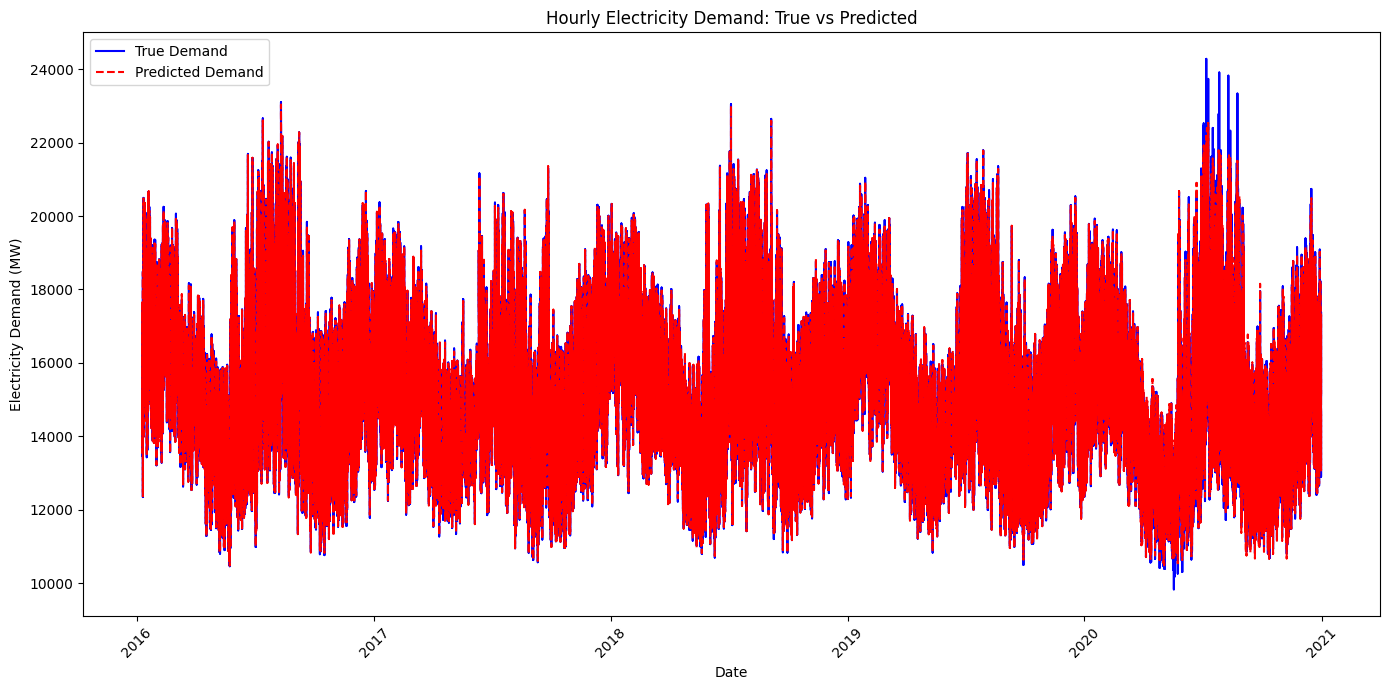

In [28]:
# Plot the hourly prediction of test and predicted set
plt.figure(figsize=(14, 7))
plt.plot(results.index, results['True Demand'], label='True Demand', color='blue')
plt.plot(results.index, results['Predicted Demand'], label='Predicted Demand', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Electricity Demand (MW)')
plt.title('Hourly Electricity Demand: True vs Predicted')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Filtering Data for Specific Day

### Filtering Data for a Specific Day
<a id="Filtering-Data-for-a-Specific-Day"></a>


In [29]:
# Filter data for a specific day from 2016-01-01 to 2020-12-31 e.g., '2020-07-20'
specific_day = '2020-07-20'
day_data = results.loc[specific_day]

# Display the filtered data
print(day_data)

            Hour  True Demand  Predicted Demand   Diff
Date                                                  
2020-07-20     0        16476      16337.740234  138.0
2020-07-20     1        14820      14673.943359  146.0
2020-07-20     2        14769      14377.351562  392.0
2020-07-20     3        14205      14367.881836 -163.0
2020-07-20     4        13722      13820.593750  -99.0
2020-07-20     5        13613      13738.956055 -126.0
2020-07-20     6        13895      14030.182617 -135.0
2020-07-20     7        14533      14712.950195 -180.0
2020-07-20     8        15939      15943.521484   -5.0
2020-07-20     9        17494      17251.503906  242.0
2020-07-20    10        18319      18100.017578  219.0
2020-07-20    11        18872      18631.556641  240.0
2020-07-20    12        19453      19278.804688  174.0
2020-07-20    13        19974      19813.039062  161.0
2020-07-20    14        19886      20144.638672 -259.0
2020-07-20    15        20011      20093.482422  -82.0
2020-07-20

## Conclusion

### Summary of Results
<a id="Summary-of-Results"></a>


1. The model shows high accuracy and reliability in predicting electricity demand, with a low Mean Squared Error (MSE) of 58854.42, Root Mean Squared Error (RMSE) of 242.60, Mean Absolute Error (MAE) of 160.81, R-squared score of 0.991, and Mean Absolute Percentage Error (MAPE) of 0.0109%.
2. The feature importance analysis ranks variables based on their contribution to predicting electricity demand:
    - demand_lag_1: Most influential, reflecting strong dependency on previous hour's demand.
    - Cos_Hour: Significant cyclic pattern impact, likely related to daily cycles.
    - Hour_8: Indicates importance of a specific hour, possibly a peak consumption period.
    - EWMA_6: Captures smoothed demand trends over time.
    - Others, like Hour_7, Hour_23, Sin_Hour, Hour_0, IsWeekend_0, and demand_lag_2, also contribute but to a lesser extent.

### Future Work
<a id="Future-Work"></a>


1. **Incorporate Additional External Variables**: Consider integrating economic indicators and population demographics alongside weather data to enhance prediction accuracy and capture broader influences on electricity demand.

2. **Advanced Modeling Techniques**: Explore the application of advanced algorithms such as LSTM networks to improve the model's ability to handle complex temporal dependencies and enhance forecasting accuracy.

3. **Spatial Analysis**: Extend the analysis to include regional variations in electricity demand by leveraging geographic data. This approach can provide tailored predictions and optimize resource allocation strategies based on localized demand patterns.

### References
<a id="References"></a>
- **Canada holidays**: Available at: [https://pypi.org/project/holidays/](https://pypi.org/project/holidays/).

- **Canada Seasons**: Available at: [https://www.durhamimmigration.ca/en/moving-to-durham-region/weather---four-seasons.aspx](https://www.durhamimmigration.ca/en/moving-to-durham-region/weather---four-seasons.aspx).

- **XGBoost Documentation**: Official XGBoost Documentation. Available at: [https://xgboost.readthedocs.io/](https://xgboost.readthedocs.io/).

- **Edgecom-AI Data Source**: Data sourced from edgecom-ai for the electricity demand prediction project.
